c:\Users\white\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4371 - loss: 1.3645 - val_accuracy: 0.9237 - val_loss: 0.5984
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7825 - loss: 0.6793 - val_accuracy: 0.9570 - val_loss: 0.3191
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8600 - loss: 0.4767 - val_accuracy: 0.9592 - val_loss: 0.2461
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8744 - loss: 0.4264 - val_accuracy: 0.9603 - val_loss: 0.2199
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8995 - loss: 0.3737 - val_accuracy: 0.9597 - val_loss: 0.2041
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9056 - loss: 0.3518 - val_accuracy: 0.9617 - val_loss: 0.1930
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9060 - loss: 0.3389 - val_accuracy: 0.9628 - val_loss: 0.1844
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9182 - loss: 0.3121 - val_accuracy:

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.9509    0.9303    0.9405       832
           1     1.0000    1.0000    1.0000       742
           2     0.8769    0.9783    0.9248       830
           3     1.0000    1.0000    1.0000       771
           4     1.0000    0.9055    0.9504       825

    accuracy                         0.9615      4000
   macro avg     0.9655    0.9628    0.9631      4000
weighted avg     0.9642    0.9615    0.9618      4000



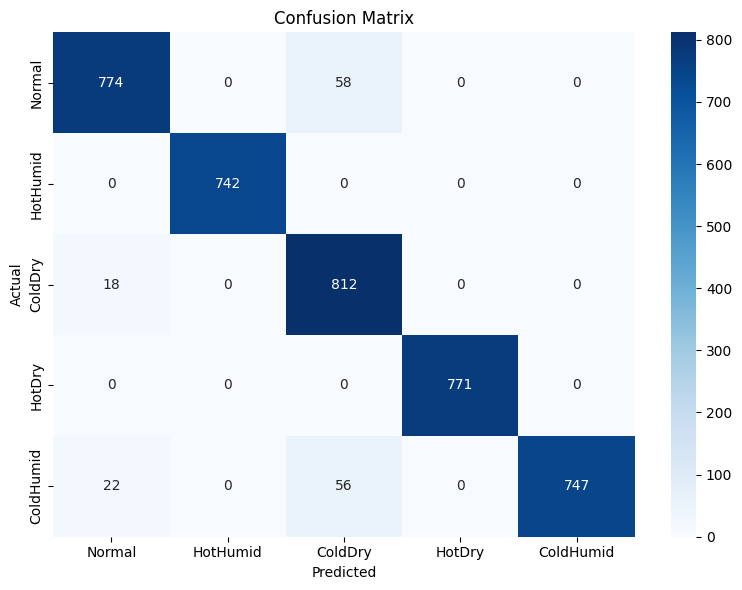

In [1]:
# with confusion matrix and classification report
# This code generates synthetic data for a DHT sensor classification problem and trains a neural network to classify the data into 5 classes.
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Seed for reproducibility
np.random.seed(42)
random.seed(42)

# Generate synthetic, slightly noisy and overlapping data
def generate_data(samples=15000):
    X, y = [], []

    for _ in range(samples):
        r = random.random()
        if r < 0.2:
            temp = random.uniform(20, 28)
            hum = random.uniform(40, 60)
            label = 0
        elif r < 0.4:
            temp = random.uniform(29, 40)
            hum = random.uniform(61, 90)
            label = 1
        elif r < 0.6:
            temp = random.uniform(5, 17)
            hum = random.uniform(10, 39)
            label = 2
        elif r < 0.8:
            temp = random.uniform(29, 40)
            hum = random.uniform(10, 39)
            label = 3
        else:
            temp = random.uniform(5, 17)
            hum = random.uniform(61, 90)
            label = 4

        # Add noise
        temp += np.random.normal(0, 0.5)
        hum += np.random.normal(0, 1.0)

        # Add some ambiguous borderline cases
        if random.random() < 0.05:
            temp = random.uniform(17, 20)
            hum = random.uniform(39, 41)
            label = random.choice([0, 2, 4])

        X.append([temp, hum])
        y.append(label)

    return np.array(X), np.array(y)

# Generate data
X, y = generate_data(20000)

# Normalize
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_norm = (X - X_min) / (X_max - X_min)

# Split manually for full control
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_norm, y, test_size=0.2, random_state=42, stratify=y)

# Build model
model = Sequential([
    Dense(16, activation='relu', input_shape=(2,), kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
model.fit(X_train, y_train, epochs=10, batch_size=32,
          validation_data=(X_val, y_val),
          callbacks=[early_stop],verbose=1)

# Save model and normalization
model.save("dht_classifier.h5")
np.savez("normalization.npz", min=X_min, max=X_max)

# Evaluate on validation set
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
labels = ['Normal', 'HotHumid', 'ColdDry', 'HotDry', 'ColdHumid']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()